## Market Analysis

Loading data from ../../../../data/processed/gdelt_ohlcv_join.csv...
 Data Loaded Successfully: 2584 rows.

 MARKET REGIME REPORT

1.  Average Annualized Volatility:
| ticker   |   volatility_proxy |
|:---------|-------------------:|
| AAPL     |          0.0253811 |
| AMZN     |          0.0558861 |
| GOOGL    |          0.019289  |
| META     |          0.0406532 |
| MSFT     |          0.0747186 |
| NVDA     |          0.02672   |
| TSLA     |          0.0794749 |

2.  Return Distribution by Sentiment Bucket:
| sentiment_bucket   |         mean |        std |   count |
|:-------------------|-------------:|-----------:|--------:|
| High               | -0.000317894 | 0.00361847 |     109 |
| Low                |  0.00017984  | 0.00466591 |     329 |
| Neutral            | -0.000153824 | 0.0050768  |    2006 |

    Insight: Sentiment does not clearly differentiate returns.

3.  Return Distribution by Volume Bucket:
| volume_bucket   |   Avg Absolute Move |   Count |
|:----------------

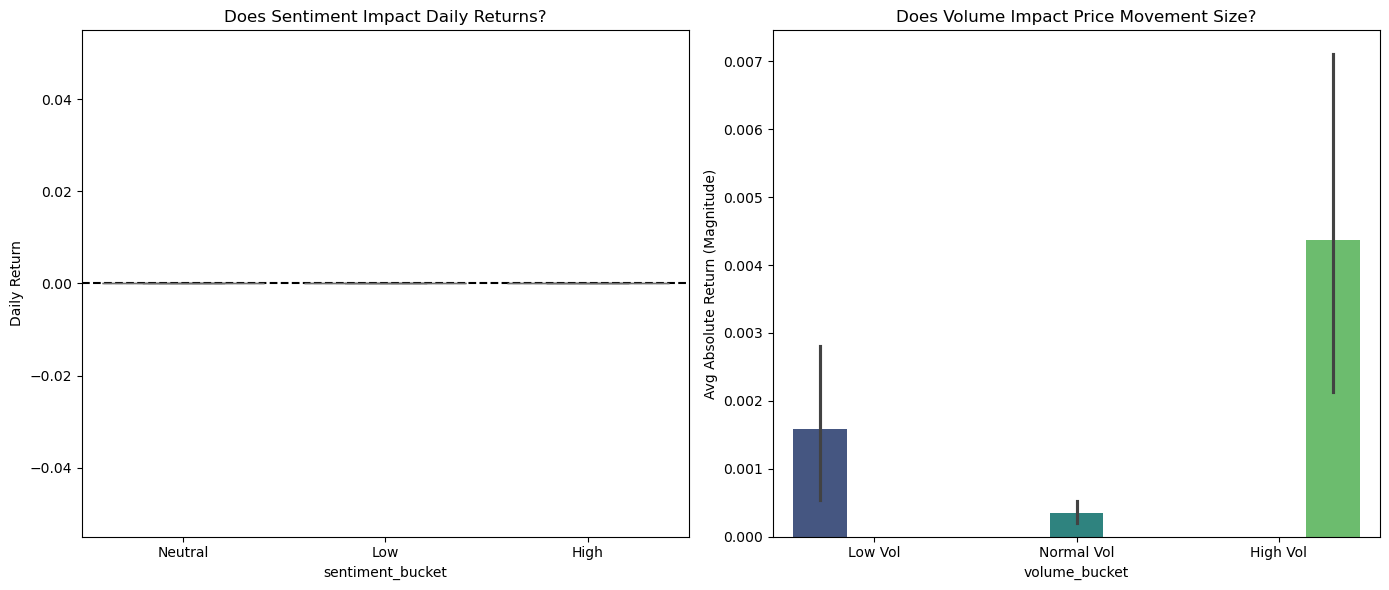

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

FILE_PATH = "../../../../data/processed/gdelt_ohlcv_join.csv" 

def analyze_market_regimes(file_path):
    print(f"Loading data from {file_path}...")
    
    # 1. Load Data
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        # Fallback for notebook relative paths or missing files
        print(f"File not found at {file_path}")
        return

    # map specific column names to the standard names the script needs.
    rename_map = {
        'price_date': 'date',
        # 'article_date': 'date',    # Fallback if price_date is missing
        'next_close': 'close',
        'Close': 'close',          # Fallback
        'next_volume': 'volume',
        'Volume': 'volume',        # Fallback
        'next_open': 'open',
        'Open': 'open'             # Fallback
    }
    
    # Apply the renaming
    df.rename(columns=rename_map, inplace=True)
    
    # VALIDATION: Check if we have the Big 3 columns
    required_cols = ['date', 'close', 'volume']
    missing = [col for col in required_cols if col not in df.columns]
    
    if missing:
        print(f"   CRITICAL ERROR: Could not find columns: {missing}")
        print(f"   Your available columns are: {df.columns.tolist()}")
        return

    # Standardize Dates
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['ticker', 'date'])
    
    print(f" Data Loaded Successfully: {len(df)} rows.")

    # Close-Close % Return
    df['daily_return'] = df.groupby('ticker')['close'].pct_change()
    
    # Absolute Return (Magnitude of move, directionless)
    df['abs_return'] = df['daily_return'].abs()
    
    # We use a 20 day Rolling Standard Deviation of returns (Annualized)
    df['volatility_proxy'] = df.groupby('ticker')['daily_return'].transform(
        lambda x: x.rolling(window=20).std()
    )

    # Drop NaN values generated by shifting/rolling
    df = df.dropna(subset=['daily_return', 'volatility_proxy'])

    # Sentiment Buckets
    # Logic: "High" is top 33%, "Low" is bottom 33% relative to ticker's history.
    
    def bucket_sentiment(group):
        try:
            # qcut to divide into equal sized buckets
            return pd.qcut(group['sentiment_score'], 3, labels=["Low", "Neutral", "High"])
        except ValueError:
            # Fallback if all sentiment scores are identical
            return pd.Series(["Neutral"] * len(group), index=group.index)

    if 'sentiment_score' in df.columns:
        df['sentiment_bucket'] = df.groupby('ticker').apply(bucket_sentiment).reset_index(level=0, drop=True)
    else:
        print(" Warning: 'sentiment_score' column missing. Skipping sentiment buckets.")

    # Volume Buckets
    # RVOL = Today's Vol / 20-Day Average Vol
    df['avg_volume_20d'] = df.groupby('ticker')['volume'].transform(lambda x: x.rolling(20).mean())
    df['rvol'] = df['volume'] / df['avg_volume_20d']
    
    # Bucket: Low (< 0.8x), Normal (0.8x - 1.2x), High (> 1.2x)
    bins = [-np.inf, 0.8, 1.2, np.inf]
    labels = ['Low Vol', 'Normal Vol', 'High Vol']
    df['volume_bucket'] = pd.cut(df['rvol'], bins=bins, labels=labels)


    print("\n==================================================")
    print(" MARKET REGIME REPORT")
    print("==================================================")
    
    # 1. Volatility Inspection
    avg_vol = df.groupby('ticker')['volatility_proxy'].mean() * np.sqrt(252) # Annualized
    print(f"\n1.  Average Annualized Volatility:")
    print(avg_vol.to_markdown())

    # 2. Return Distribution by Sentiment
    if 'sentiment_bucket' in df.columns:
        print(f"\n2.  Return Distribution by Sentiment Bucket:")
        sent_stats = df.groupby('sentiment_bucket')['daily_return'].agg(['mean', 'std', 'count'])
        print(sent_stats.to_markdown())
        
        try:
            if sent_stats.loc['High', 'mean'] > sent_stats.loc['Low', 'mean']:
                print("\n    Insight: 'High Sentiment' days have higher average returns.")
            else:
                print("\n    Insight: Sentiment does not clearly differentiate returns.")
        except KeyError:
            pass 

    # 3. Return Distribution by Volume
    print(f"\n3.  Return Distribution by Volume Bucket:")
    vol_stats = df.groupby('volume_bucket')['abs_return'].agg(['mean', 'count'])
    vol_stats.columns = ['Avg Absolute Move', 'Count']
    print(vol_stats.to_markdown())
    
    print("\n   (Note: High Volume usually corresponds to larger Absolute Moves/Volatility)")

    # VISUALIZATION 
    plot_distributions(df)
    
    return df

def plot_distributions(df):
    plt.figure(figsize=(14, 6))

    # Plot 1: Sentiment vs Returns
    if 'sentiment_bucket' in df.columns:
        plt.subplot(1, 2, 1)
        sns.boxplot(x='sentiment_bucket', y='daily_return', hue='sentiment_bucket', data=df, palette="coolwarm", showfliers=False, legend=False)
        plt.title("Does Sentiment Impact Daily Returns?")
        plt.axhline(0, color='black', linestyle='--')
        plt.ylabel("Daily Return")

    # Plot 2: Volume vs Volatility (Absolute Return)
    plt.subplot(1, 2, 2)
    sns.barplot(x='volume_bucket', y='abs_return', hue='volume_bucket', data=df, palette="viridis", legend=False)
    plt.title("Does Volume Impact Price Movement Size?")
    plt.ylabel("Avg Absolute Return (Magnitude)")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    df_regime = analyze_market_regimes(FILE_PATH)

## Summary of Findings

### Volatility by Stock
- Highest volatility: TSLA (0.0795), MSFT (0.0747), AMZN (0.0559)
- Moderate volatility: META (0.0407), NVDA (0.0267)
- Lowest volatility: AAPL (0.0254), GOOGL (0.0193)

### Sentiment vs Returns
- Mean returns across sentiment buckets are near zero.
- No clear relationship between sentiment and return direction.
- Sentiment alone is not a reliable predictor of returns.

### Volume vs Price Movement
- High volume → largest price moves (0.00437 avg absolute move)
- Low volume → moderate moves (0.00158)
- Normal volume → smallest moves (0.00035)
- Volume is strongly associated with volatility.

### Key Takeaways
- Volume is a strong predictor of volatility.
- Sentiment has weak predictive value for direction.
- Best predictive features to prioritize for price: volume and volatility.


# news_gap_impact.py script
This script is just in case sentiment score improves as well as its predictive power
## IGNORE FOR NOW

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
FILE_PATH = "data/processed/gdelt_ohlcv_join.csv" 

def analyze_news_impact(file_path):
    print(f"Loading data from {file_path}...")
    
    # 1. Load Data
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(" File not found. Please check the path.")
        return

    # 2. Data Prep
    df['price_date'] = pd.to_datetime(df['price_date'])
    original_count = len(df)
    df = df[df['sentiment_score'] != 0].copy()
    df = df[df['sentiment_score'].abs() > 0.2].copy()
    dropped_count = original_count - len(df)
    print(f"🧹 Filtered Data: Removed {dropped_count} articles with 0 sentiment.")
    print(f"   (Remaining articles: {len(df)})")

    # 3. Aggregation (Critical Step)
    daily_df = df.groupby(['ticker', 'price_date']).agg({
        'sentiment_score': 'mean',         
        'next_open': 'first',               
        'next_close': 'first',
        'title': 'count'
    }).reset_index()
    
    daily_df.rename(columns={'title': 'article_count'}, inplace=True)
    daily_df = daily_df.sort_values(['ticker', 'price_date'])

    # 4. Calculate Overnight Gap
    daily_df['prev_close'] = daily_df.groupby('ticker')['next_close'].shift(1)
    daily_df['gap_pct'] = ((daily_df['next_open'] - daily_df['prev_close']) / daily_df['prev_close']) * 100

    # Drop the first row
    daily_df = daily_df.dropna()

    # 5. filter for days where the Gap was > 1% (Significant)
    big_gaps = daily_df[daily_df['gap_pct'].abs() > 1.0].copy()
    
    # 6. Check Correlation
    # Does high sentiment lead to a positive gap?
    correlation = daily_df['sentiment_score'].corr(daily_df['gap_pct'])


    print(f"\n==================================================")
    print(f" NEWS SENTIMENT vs. PRICE GAPS")
    print(f"==================================================")
    print(f"Total Trading Days Analyzed: {len(daily_df)}")
    print(f"Correlation (Sentiment -> Gap): {correlation:.4f}")
    
    if correlation > 0.1:
        print("    Insight: Positive sentiment predicts positive gaps (Market follows news).")
    elif correlation < -0.1:
        print("    Insight: Negative correlation (Market 'Sells the News').")
    else:
        print("    Insight: No strong link between sentiment and opening price.")

    print(f"\n TOP 5 BIGGEST OVERNIGHT GAPS & SENTIMENT:")
    # Sort by magnitude of the gap
    top_moves = big_gaps.sort_values('gap_pct', key=abs, ascending=False).head(5)
    
    if top_moves.empty:
        print("   No gaps > 1.0% found.")
    else:
        print(f"{'Date':<12} | {'Gap %':<10} | {'Sentiment':<10} | {'Articles'}")
        print("-" * 50)
        for _, row in top_moves.iterrows():
            date_str = row['price_date'].strftime('%Y-%m-%d')
            print(f"{date_str:<12} | {row['gap_pct']:+.2f}%     | {row['sentiment_score']:.2f}       | {row['article_count']}")

if __name__ == "__main__":
    analyze_news_impact(FILE_PATH)